In [1]:
# 📦 Importations
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import MobileViTForImageClassification, AutoImageProcessor
import matplotlib.pyplot as plt
import numpy as np
import os

/home/zoidberg/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 📂 Préparer les données
data_dir = "/home/zoidberg/Zoidberg/data/raw/chest_Xray/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
classes = dataset.classes
print("Classes :", classes)

Classes : ['NORMAL', 'PNEUMONIA']


In [3]:
# 🚀 Charger MobileViT pré-entraîné
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# ⚙️ Optimiseur et perte
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses = []
train_accuracies = []

In [5]:
# 🏋️ Boucle d'entraînement
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

Epoch [1/5] - Loss: 0.5604 - Accuracy: 80.61%


Epoch [2/5] - Loss: 0.3484 - Accuracy: 93.11%


Epoch [3/5] - Loss: 0.2085 - Accuracy: 95.99%


Epoch [4/5] - Loss: 0.1646 - Accuracy: 97.12%


Epoch [5/5] - Loss: 0.1085 - Accuracy: 98.24%


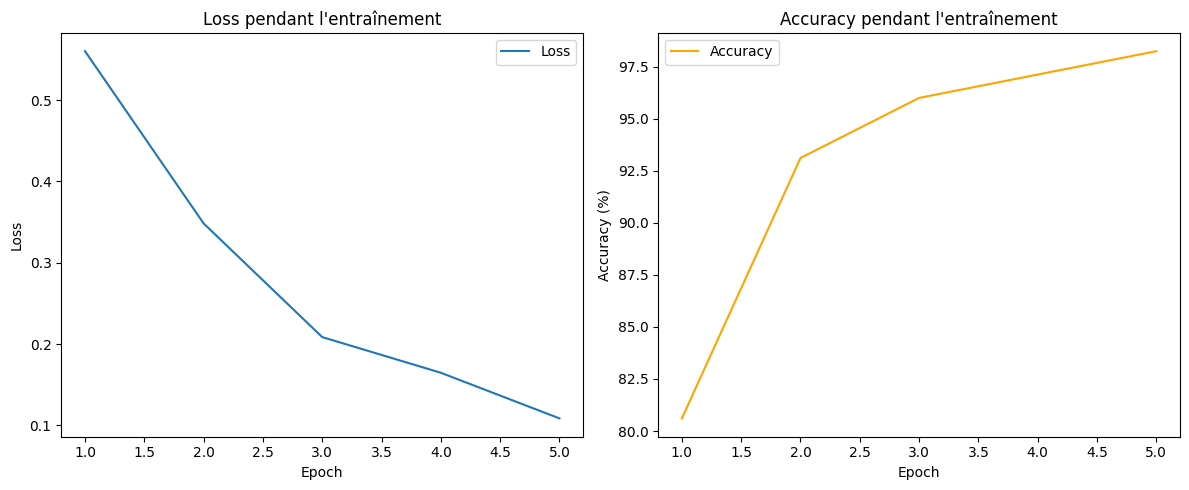

In [6]:
# 📈 Afficher les courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss pendant l\'entraînement')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy pendant l\'entraînement')
plt.legend()
plt.tight_layout()
plt.show()

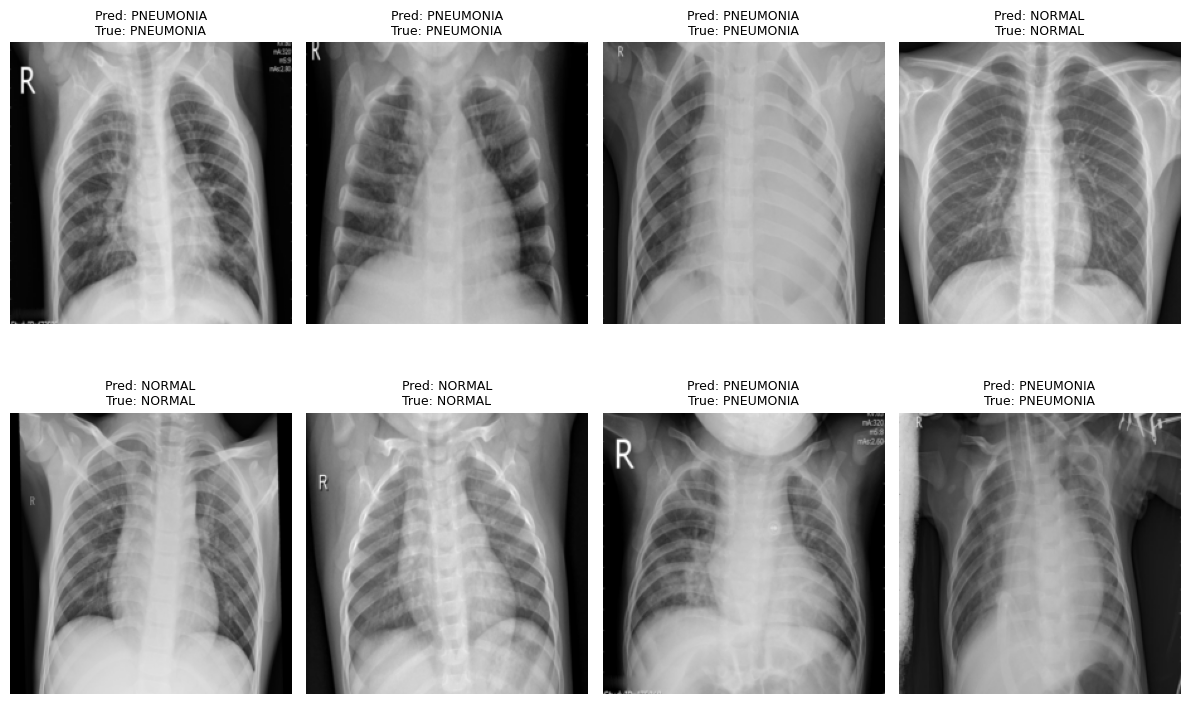

In [7]:
# 🔎 Tester quelques images
model.eval()
inputs, labels = next(iter(dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs).logits
_, preds = torch.max(outputs, 1)
plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# 💾 Sauvegarde
torch.save(model.state_dict(), "../models/test_guca_pneumonia.pth")
print("Modèle sauvegardé ✅")

Modèle sauvegardé ✅


In [9]:
# 📄 Rapport automatique
!jupyter nbconvert --to html --output-dir=../docs/ test_guca.ipynb
!jupyter nbconvert --to pdf --output-dir=../docs/ test_guca.ipynb
print("Rapports HTML et PDF générés ✅")

[NbConvertApp] Converting notebook test_guca.ipynb to html


[NbConvertApp] Writing 292766 bytes to ../docs/test_guca.html


[NbConvertApp] Converting notebook test_guca.ipynb to pdf


[NbConvertApp] Writing 33380 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/home/zoidberg/.local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/zoidberg/.local/lib/python3.12/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/home/zoidberg/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/zoidberg/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/home/zoidberg/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/home/zoidberg/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_

Rapports HTML et PDF générés ✅
